In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pickle
import glob, os

In [8]:
results = {}
result_files = glob.glob('../../results/*.pickle')
for file in result_files:
    print(file)
    results[os.path.basename(file).split('.')[0]] = pickle.load(open(file, 'rb'))

../../results/paul_pDCA.pickle
../../results/sim_pca_mse.pickle
../../results/paul_n2s_DCA.pickle
../../results/sim_DCA.pickle
../../results/sim_diffusion_poisson.pickle
../../results/hca_diffusion_poisson.pickle
../../results/hca_pca_mse.pickle
../../results/sim_n2s_DCA.pickle
../../results/paul_n2s_pDCA.pickle
../../results/sim_pDCA.pickle
../../results/hca_diffusion_mse.pickle
../../results/paul_DCA.pickle
../../results/sim_diffusion_mse.pickle
../../results/sim_n2s_pDCA.pickle


In [4]:
hca_pca_mse = results['hca_pca_mse']
hca_diffusion_mse = results['hca_diffusion_mse']

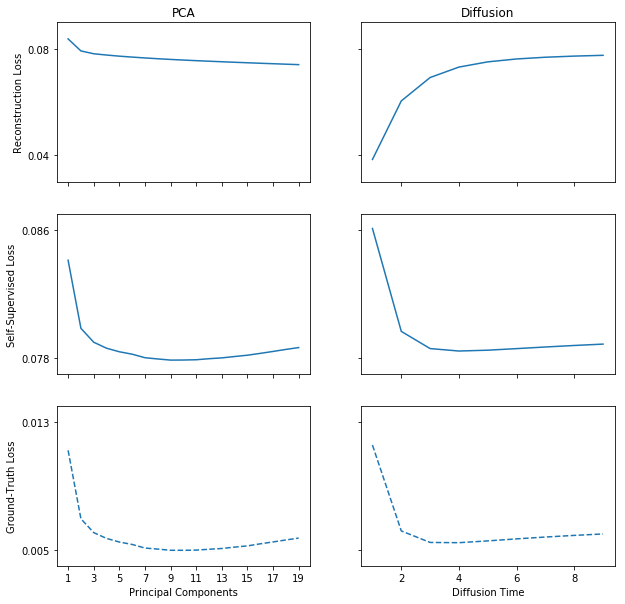

In [5]:
fig, ax = plt.subplots(3, 2, sharex = 'col', sharey='row', figsize=(10,10))

k_range = hca_pca_mse['param_range']
ax[0,0].plot(k_range, hca_pca_mse['re_loss'])
ax[0,0].set_title("PCA")
ax[0,0].set_ylabel('Reconstruction Loss')
ax[0,0].set_yticks([0.04, 0.08])
ax[0,0].set_ylim(0.03, 0.09)

displacement = 0.073
ax[1,0].plot(k_range, hca_pca_mse['ss_loss'])
ax[1,0].set_ylabel('Self-Supervised Loss')
ax[1,0].set_yticks([0.078, 0.086])
ax[1,0].set_ylim(0.077, 0.087)

ax[2,0].plot(k_range, hca_pca_mse['gt_loss'], '--')
ax[2,0].set_ylabel('Ground-Truth Loss')
ax[2,0].set_xlabel('Principal Components')
ax[2,0].set_xticks(np.arange(1,20, 2))
ax[2,0].set_yticks([0.078 - displacement, 0.086 - displacement])
ax[2,0].set_ylim(0.077 - displacement, 0.087 - displacement)

init_time = 1
t_range = hca_diffusion_mse['param_range']
ax[0,1].plot(t_range[init_time:], hca_diffusion_mse['re_loss'][init_time:])
ax[0,1].set_title("Diffusion")

ax[1,1].plot(t_range[init_time:], hca_diffusion_mse['ss_loss'][init_time:])
ax[2,1].plot(t_range[init_time:], hca_diffusion_mse['gt_loss'][init_time:], '--')
ax[2,1].set_xlabel('Diffusion Time')

plt.savefig('figures/hca_mse.svg')

# Simulated

Text(0.5,0,'Bottleneck Width')

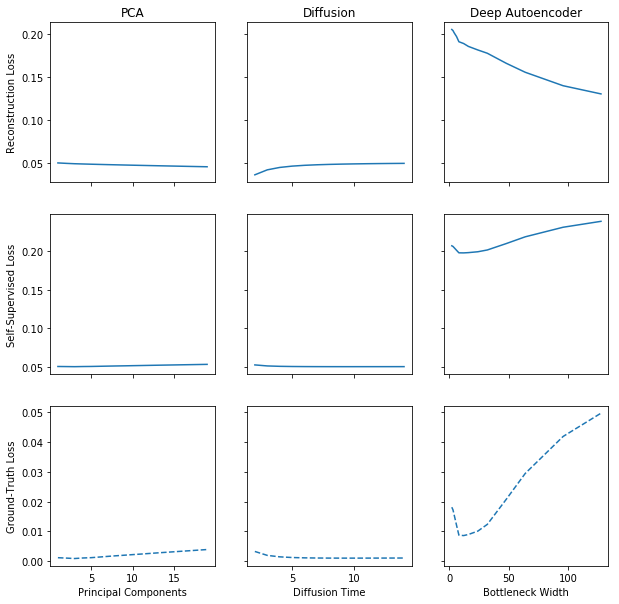

In [21]:
sim_pca_mse = results['sim_pca_mse']
sim_diffusion_mse = results['sim_diffusion_mse']
sim_dca_mse = results['sim_DCA']


fig, ax = plt.subplots(3, 3, sharex = 'col', sharey='row', figsize=(10,10))

k_range = sim_pca_mse['param_range']
ax[0,0].plot(k_range, sim_pca_mse['re_loss'])
ax[0,0].set_title("PCA")
ax[0,0].set_ylabel('Reconstruction Loss')


displacement = 0.073
ax[1,0].plot(k_range, sim_pca_mse['ss_loss'])
ax[1,0].set_ylabel('Self-Supervised Loss')


ax[2,0].plot(k_range, sim_pca_mse['gt_loss'], '--')
ax[2,0].set_ylabel('Ground-Truth Loss')
ax[2,0].set_xlabel('Principal Components')

init_time = 2
t_range = sim_diffusion_mse['param_range']
ax[0,1].plot(t_range[init_time:], sim_diffusion_mse['re_loss'][init_time:])
ax[0,1].set_title("Diffusion")

ax[1,1].plot(t_range[init_time:], sim_diffusion_mse['ss_loss'][init_time:])
ax[2,1].plot(t_range[init_time:], sim_diffusion_mse['gt_loss'][init_time:], '--')
ax[2,1].set_xlabel('Diffusion Time')


bottlenecks = sim_dca_mse['param_range']
ax[0,2].plot(bottlenecks, sim_dca_mse['re_loss'])
ax[0,2].set_title("Deep Autoencoder")

ax[1,2].plot(bottlenecks, sim_dca_mse['ss_loss'])
ax[2,2].plot(bottlenecks, sim_dca_mse['gt_loss'], '--')
ax[2,2].set_xlabel('Bottleneck Width')


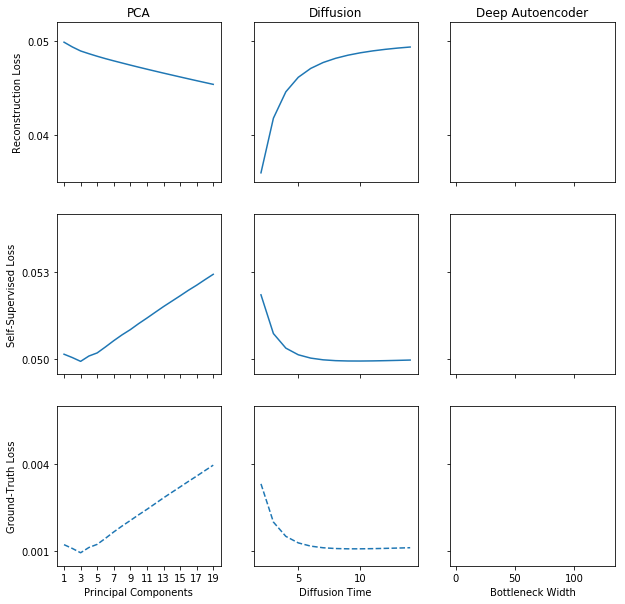

In [14]:
sim_pca_mse = results['sim_pca_mse']
sim_diffusion_mse = results['sim_diffusion_mse']
sim_dca_mse = results['sim_DCA']

fig, ax = plt.subplots(3, 3, sharex = 'col', sharey='row', figsize=(10,10))

k_range = sim_pca_mse['param_range']
ax[0,0].plot(k_range, sim_pca_mse['re_loss'])
ax[0,0].set_title("PCA")
ax[0,0].set_ylabel('Reconstruction Loss')
ax[0,0].set_yticks([0.04, 0.05])
ax[0,0].set_ylim(0.035, 0.052)

displacement = 0.049
ax[1,0].plot(k_range, sim_pca_mse['ss_loss'])
ax[1,0].set_ylabel('Self-Supervised Loss')
ax[1,0].set_yticks([0.05, 0.053])
ax[1,0].set_ylim(0.0495, 0.055)

ax[2,0].plot(k_range, sim_pca_mse['gt_loss'], '--')
ax[2,0].set_ylabel('Ground-Truth Loss')
ax[2,0].set_xlabel('Principal Components')
ax[2,0].set_xticks(np.arange(1,20, 2))
ax[2,0].set_yticks([0.05 - displacement, 0.053 - displacement])
ax[2,0].set_ylim(0.0495 - displacement, 0.055 - displacement)

init_time = 2
t_range = sim_diffusion_mse['param_range']
ax[0,1].plot(t_range[init_time:], sim_diffusion_mse['re_loss'][init_time:])
ax[0,1].set_title("Diffusion")

ax[1,1].plot(t_range[init_time:], sim_diffusion_mse['ss_loss'][init_time:])
ax[2,1].plot(t_range[init_time:], sim_diffusion_mse['gt_loss'][init_time:], '--')
ax[2,1].set_xlabel('Diffusion Time')

bottlenecks = sim_dca_mse['param_range']
ax[0,2].plot(bottlenecks, sim_dca_mse['re_loss'])
ax[0,2].set_title("Deep Autoencoder")

ax[1,2].plot(bottlenecks, sim_dca_mse['ss_loss'])
ax[2,2].plot(bottlenecks, sim_dca_mse['gt_loss'], '--')
ax[2,2].set_xlabel('Bottleneck Width')

plt.savefig('figures/sim_mse.svg')

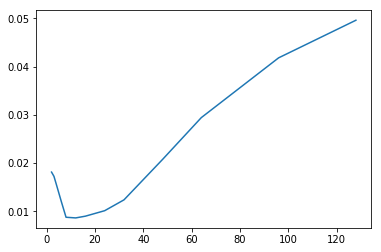

In [19]:
plt.plot(bottlenecks, sim_dca_mse['gt_loss'])